# Interpreting Bi-LSTM Sentiment Classification Models With Integrated Gradients

This notebook loads the pretrained Bi-LSTM model following [PaddleNLP TextClassification](https://github.com/PaddlePaddle/models/tree/release/2.0-beta/PaddleNLP/examples/text_classification/rnn) and performs sentiment analysis on reviews data. The full official PaddlePaddle sentiment classification tutorial can be found [here](https://github.com/PaddlePaddle/models/tree/release/2.0-beta/PaddleNLP/examples/text_classification). 

Interpretations of the predictions are generated and visualized using Integrated Gradients algorithm, specifically the `IntGradNLPInterpreter` class.

In [1]:
import paddle
import numpy as np
import interpretdl as it
from interpretdl.data_processor.visualizer import VisualizationTextRecord, visualize_text

If you have't done so, please first download the word dictionary that maps each word to an id.

In [ ]:
# downloads the word dict to assets/
!wget https://paddlenlp.bj.bcebos.com/data/senta_word_dict.txt -P assets/

Load the word dict and specify the pretrained model path. 

To obtain the pretrained weights, please train a bilstm model following the [tutorial](https://github.com/PaddlePaddle/models/tree/release/2.0-beta/PaddleNLP/examples/text_classification/rnn) and specify the final `.pdparams` file position in `PARAMS_PATH` below.

In [2]:
def load_vocab(vocab_file):
    """Loads a vocabulary file into a dictionary."""
    vocab = {}
    with open(vocab_file, "r", encoding="utf-8") as reader:
        tokens = reader.readlines()
    for index, token in enumerate(tokens):
        token = token.rstrip("\n").split("\t")[0]
        vocab[token] = index
    return vocab

PARAMS_PATH = "assets/final.pdparams"
VOCAB_PATH = "assets/senta_word_dict.txt"

vocab = load_vocab(VOCAB_PATH)

Initialize the BiLSTM model using **paddlenlp.models** and load pretrained weights.

In [3]:
import paddlenlp as ppnlp
model = ppnlp.models.Senta(
        network='bilstm',
        vocab_size=len(vocab),
        num_classes=2)

state_dict = paddle.load(PARAMS_PATH)
model.set_dict(state_dict)

Initialize the `IntGradNLPInterpreter`. 

In [4]:
ig = it.IntGradNLPInterpreter(model, True)

Define the reviews that we want to analyze. 

In [5]:
reviews = [
    '这个宾馆比较陈旧了，特价的房间也很一般。总体来说一般',
    '作为老的四星酒店，房间依然很整洁，相当不错。机场接机服务很好，可以在车上办理入住手续，节省时间。'
]

Define a preprocessing function that processes a list of raw strings into model inputs.

In [6]:
import jieba
def preprocess_fn(data):
    texts = []
    seq_lens = []
    for text in data:
        tokens = " ".join(jieba.cut(text)).split(' ')
#         tokens = text.split()
        ids = []
        unk_id = vocab.get('[UNK]', None)
        for token in tokens:
            wid = vocab.get(token, unk_id)
            if wid:
                ids.append(wid)
        texts.append(ids)
        seq_lens.append(len(ids))

    pad_token_id = 0
    max_seq_len = max(seq_lens)
    for index, text in enumerate(texts):
        seq_len = len(text)
        if seq_len < max_seq_len:
            padded_tokens = [pad_token_id for _ in range(max_seq_len - seq_len)]
            new_text = text + padded_tokens
            texts[index] = new_text
        elif seq_len > max_seq_len:
            new_text = text[:max_seq_len]
            texts[index] = new_text
    texts = paddle.to_tensor(texts)
    texts.stop_gradient = False
    seq_lens = paddle.to_tensor(seq_lens)
    seq_lens.stop_gradient = False
    return texts, seq_lens

In the cell below, we `interpret` reviews and grab weights for each token.

Since the output gradients are not grouped by reviews due to the LoDTensor inputs, we use the LoD information to group them into a list of lists.

In [7]:
pred_labels, pred_probs, avg_gradients = ig.interpret(
    preprocess_fn(reviews),
    return_pred=True,
    visual=True)

sum_gradients = np.sum(avg_gradients, axis=-1).tolist()

new_array = []
for i in range(len(reviews)):
    new_array.append(
        list(zip(" ".join(jieba.cut(reviews[i])).split(' '), sum_gradients[i])))

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.837 seconds.
Prefix dict has been built successfully.


For visualizasion purposes, word weights in each review are normalized to better illustrate differences between weights. Results for each review is stored in a list by making use of the `VisualizationTextRecord`.

In [8]:
true_labels = [1, 0]
recs = []
for i, l in enumerate(new_array):
    words = [t[0] for t in l]
    word_importances = [t[1] for t in l]
    word_importances = np.array(word_importances) / np.linalg.norm(
        word_importances)
    pred_label = pred_labels[i]
    pred_prob = pred_probs[i]
    true_label = true_labels[i]
    interp_class = pred_label
    if interp_class == 0:
        word_importances = -word_importances
    recs.append(
        VisualizationTextRecord(words, word_importances, true_label,
                                pred_label, pred_prob, interp_class))

visualize_text(recs)

The above cell's output is similar to the following:

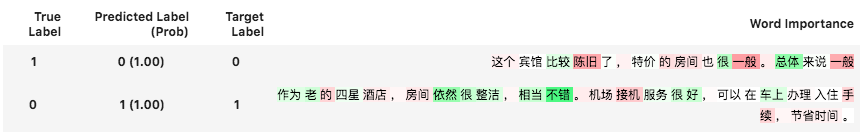

In [10]:
from IPython.display import Image
Image(filename='assets/int_grad_nlp_viz.png')